Enter the ingredient you would like to test, or press <enter> to quit.
(Examples: sugar, kale, tofu, lamb, bread crumb, jackfruit ... )

Ingredient: kale
Extracting and cleaning data ...

The average rating for recipes with kale, based on 1256 samples, is 4.180732484076433.
The average rating for recipes without kale, based on 718999 samples, is 4.425042315775126.

Applying Mann-Whitney U-Test ...

With 99% confidence, we reject the hypothesis that the two distributions have the same mean.  (p = 5.905318082679729e-06)
Plot the rating comparison for recipes with/without this ingredient? (y/n) y


<IPython.core.display.Javascript object>


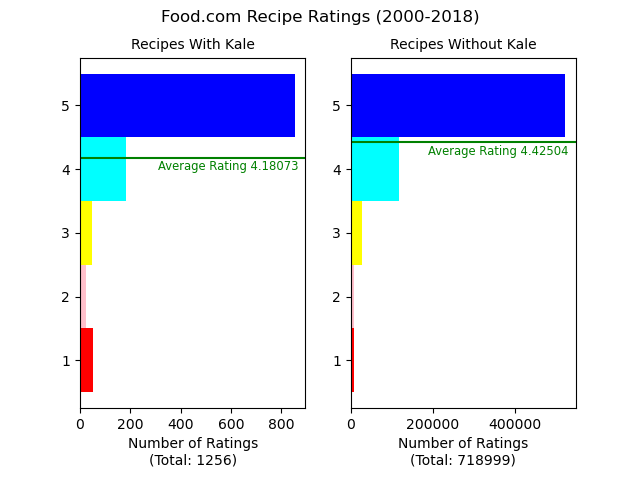

Plot saved as 'plot.png'


In [6]:
"""
Prompts the user for a choice of ingredient, then compares all Food.com recipes
including that ingredient against all recipes not including that ingredient.
If the sample sizes are sufficiently large, runs a Mann-Whitney U-test
to determine if the gap in mean ratings is statistically significant.
If desired, plots the distributions to a horizontal bar chart.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from scipy import stats

%matplotlib notebook

def get_ingr_map(): 
    #Return a DataFrame with index = ingredients, column = ingredient codes.
    infile = open("datasets-raw/ingr_map.pkl",'rb')
    ingr_map = pickle.load(infile)
    infile.close()
    ingr_map = ingr_map[['replaced','id']].set_index('replaced').drop_duplicates().sort_index()
    return ingr_map
    
def get_cleaned_datasets(ingr):
    # Extract and combine ingredient and rating info from raw datasets.
    # Return a pair of DataFrames, first is recipes w/ ingr, second is recipes without.
    if os.access("datasets-raw/",os.F_OK):
        print('Extracting and cleaning data ...\n')
        df1 = pd.read_csv('datasets-raw/PP_recipes1.csv')
        df2 = pd.read_csv('datasets-raw/PP_recipes2.csv')
        df3 = pd.read_csv('datasets-raw/PP_recipes3.csv')
        df = pd.concat([df1,df2,df3],ignore_index=True)
        df = df[['i','ingredient_ids']].set_index('i').sort_index()
        interactions = pd.read_csv('datasets-raw/RAW_interactions1.csv')
        for i in [2,3,4,5]:
            inappend = pd.read_csv('datasets-raw/RAW_interactions'+str(i)+'.csv')
            interactions = pd.concat([interactions,inappend],ignore_index=True)
        interactions = interactions[['recipe_id','rating']].set_index('recipe_id').sort_index()
        df = pd.merge(df,interactions,how='inner',left_index=True,right_index=True)
        df.index.rename('recipe_id',inplace=True)
        ingr_map = get_ingr_map()
        ingr_id = ingr_map.loc[ingr.lower()]['id']
        dfGood = df[df['ingredient_ids'].str.contains(str(ingr_id))]
        dfBad = df[~df['ingredient_ids'].str.contains(str(ingr_id))]
        return(dfGood, dfBad)
    else:
        print('Cannot access directory /datasets-raw/.')
        return
    
def test_datasets(ingr):
    # Run Mann-Whitney U-Test.
    dfGood,dfBad = get_cleaned_datasets(ingr)
    countGood = len(dfGood) # Sample size with ingr
    countBad = len(dfBad)   # Sample size without ingr
    meanGood = np.average(dfGood['rating']) # Mean rating with ingr
    meanBad = np.average(dfBad['rating'])   # Mean rating without ingr
    print('The average rating for recipes with '+ingr+', based on '+str(countGood)+' samples, is '+str(meanGood)+'.')
    print('The average rating for recipes without '+ingr+', based on '+str(countBad)+' samples, is '+str(meanBad)+'.')
    print()
    if countGood <= 20:
        print('Since no more than 20 recipes contain '+ingr+', we cannot execute a meaningful hypothesis test.')
    else:
        print('Applying Mann-Whitney U-Test ...')
        print()
        (s, p) = stats.mannwhitneyu(dfGood['rating'],dfBad['rating'],alternative='two-sided')
        if p <= 0.01:
            print('With 99% confidence, we reject the hypothesis that the two distributions have the same mean.  (p = '+str(p)+')')
        elif p <= 0.05:
            print('With 95% confidence, we reject the hypothesis that the two distributions have the same mean.  (p = '+str(p)+')')
        elif p <= 0.1:
            print('With 90% confidence, we reject the hypothesis that the two distributions have the same mean.  (p = '+str(p)+')')
        else:
            print('We cannot reject the hypothesis that the distributions have the same mean.  (p = '+str(p)+')')
    plotans = input('Plot the rating comparison for recipes'+
                     ' with/without this ingredient? (y/n) ')
    if plotans.lower() == 'y':
        plot_datasets(ingr,dfGood,dfBad)
        
def plot_datasets(ingr,dfGood,dfBad):
    # Export horizontal bar chart plot of compared sample distributions to 'plot.png'.
    # For this script, the datasets are passed directly to reduce runtime.
    countGood = len(dfGood) # Sample size with ingr
    countBad = len(dfBad)   # Sample size without ingr
    meanGood = np.average(dfGood['rating']) # Mean rating with ingr
    meanBad = np.average(dfBad['rating'])   # Mean rating without ingr
    
    plt.figure()
    plt.suptitle('Food.com Recipe Ratings (2000-2018)') # Plot title
    
    yvals = np.array([1,2,3,4,5]) # Rating labels for y-axis
    y = np.arange(len(yvals))     # y-ticks
    
    plt.subplot(1,2,1) # First plot: recipes with ingr
    ratingsGood = [] # List totals for each rating for recipes
    for i in yvals:
        n = len(dfGood.where(dfGood['rating'] == i).dropna())
        ratingsGood = ratingsGood+[n]
    ratingsGood = np.array(ratingsGood)
    plt.gcf().subplots_adjust(bottom=0.15)  # Make room for two-line x labels
    plt.title('Recipes With '+ingr.capitalize(), size='medium')
    plt.xlabel('Number of Ratings\n(Total: '+str(countGood)+')')
    plt.yticks(y, yvals)
    plt.barh(y, ratingsGood, height=1, color=['red','pink','yellow','cyan','blue']) #Plot distribution
    plt.axhline(y=meanGood-1,color='green') # Plot mean rating
    plt.text(x=plt.gca().get_xlim()[1], y=meanGood-1.2, horizontalalignment='right',
             s='Average Rating '+"{:.5f}".format(meanGood)+'  ', size='smaller', color='green')

    plt.subplot(1,2,2) # Second plot: recipes without ingr
    ratingsBad = [] # List totals for each rating for recipes
    for i in yvals:
        n = len(dfBad.where(dfBad['rating'] == i).dropna())
        ratingsBad = ratingsBad + [n]
    ratingsBad = np.array(ratingsBad)
    plt.title('Recipes Without '+ingr.capitalize(), size='medium')
    plt.xlabel('Number of Ratings\n(Total: '+str(countBad)+')')
    plt.yticks(y, yvals)
    plt.barh(y, ratingsBad, height=1, color=['red','pink','yellow','cyan','blue']) #Plot distribution
    plt.axhline(y=meanBad-1,color='green') # Plot mean rating
    plt.text(x=plt.gca().get_xlim()[1], y=meanBad-1.2, horizontalalignment='right',
             s='Average Rating '+"{:.5f}".format(meanBad)+'  ', size='smaller', color='green')

    plt.savefig('plot.png') # Export plot
    print("Plot saved as 'plot.png'")

def main_loop():
    ingr_map = get_ingr_map()
    all_ingredients = ingr_map.index.tolist()
    print('Enter the ingredient you would like to test, or press <enter> to quit.')
    print('(Examples: sugar, kale, tofu, lamb, bread crumb, jackfruit ... )\n')
    ingr = input('Ingredient: ')
    while ingr.lower() not in all_ingredients:
        if ingr == '':
            break
        print('There are no recipes with that ingredient.  Please enter another or press <enter> to quit.')
        print()
        ingr = input('Ingredient: ')
    ingr = ingr.lower()
    if ingr != '':
        test_datasets(ingr)
    else:
        print('Have a nice day!')
        
main_loop()